In [2]:
%matplotlib inline

from pathlib import Path
import json
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

import tqdm
import skimage
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='skimage')

from mrcnn.config import Config
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize
from mrcnn.model import log

root_dir = Path("/home/hadim/.data/Neural_Network/Mask-RCNN/Microtubules/")

data_dir = root_dir / "data"
data_dir.mkdir(parents=True, exist_ok=True)

model_dir = root_dir / "logs"
model_dir.mkdir(parents=True, exist_ok=True)

coco_model_path = root_dir / "mask_rcnn_coco.h5"
if not coco_model_path.is_file():
    utils.download_trained_weights(str(coco_model_path))
    
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Using TensorFlow backend.


In [3]:
class MicrotubuleDataset(utils.Dataset):

    def load_microtubules(self, fnames, line_thickness=4, verbose=False):
        self.add_class("microtubule", 1, "microtubule")
        
        for i, fname in tqdm.tqdm(enumerate(fnames), total=len(fnames), disable=not verbose, leave=False):
            im = skimage.io.imread(fname)
            self.add_image("microtubule", image_id=i, path=fname,
                           width=im.shape[0], height=im.shape[1],
                           line_thickness=line_thickness)
            
    def load_image(self, image_id):
        info = self.image_info[image_id]
        im = skimage.io.imread(info["path"])
        # Convert to 8bit
        im = skimage.util.img_as_ubyte(im)
        im = skimage.exposure.rescale_intensity(im)
        # Convert to RGB
        im = skimage.color.grey2rgb(im)
        return im
                       
    def load_mask(self, image_id):

        info = self.image_info[image_id]
        json_path = info["path"].parent / (info["path"].stem + ".json")
        with open(json_path) as f:
            d = json.load(f)
            data = pd.DataFrame.from_dict(d["microtubule"])

        def get_line(x):
            d = {}
            d["start_x"] = x[x.type == "seed"]["start_x"].values[0]
            d["start_y"] = x[x.type == "seed"]["start_y"].values[0]
            d["end_x"] = x[x.type == "seed"]["end_x"].values[0]
            d["end_y"] = x[x.type == "seed"]["end_y"].values[0]
            return pd.DataFrame([d])

        def draw_line(image, line, line_thickness):
            line = np.round(line).astype("int16")
            p1 = (line["start_x"], line["start_y"])
            p2 = (line["end_x"], line["end_y"])
            _, p1, p2 = cv2.clipLine((0, 0, image.shape[0], image.shape[1]), p1, p2)
            image = cv2.line(image, p1, p2, (1,), line_thickness)
            return image

        lines = data.groupby("mt_id").apply(get_line).reset_index(drop=True)
        count = lines.shape[0]
        
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, line in lines.iterrows():
            mask[:, :, i] = draw_line(mask[:, :, i].copy(), line, info["line_thickness"])

        # Handle occlusions
        handle_occlusion = True
        if handle_occlusion:
            occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
            for i in range(count-2, -1, -1):
                mask[:, :, i] = mask[:, :, i] * occlusion
                occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))

        # Map class names to class IDs (all "microtubule" here).
        class_ids = np.repeat(self.class_names.index("microtubule"), count)

        return mask.astype(np.bool), class_ids.astype(np.int32)
    
# Split dataset
fnames = list(data_dir.glob("*.tif"))
fnames = np.random.choice(fnames, 1000)

# Build dataset
dataset = MicrotubuleDataset()
dataset.load_microtubules(fnames, verbose=True)
dataset.prepare()

{'id': 868, 'source': 'microtubule', 'path': PosixPath('/home/hadim/local/Data/Neural_Networks/Microtubules/data/image_snr_1.2_n-mts_61_id_27.tif'), 'width': 256, 'height': 256, 'line_thickness': 4}


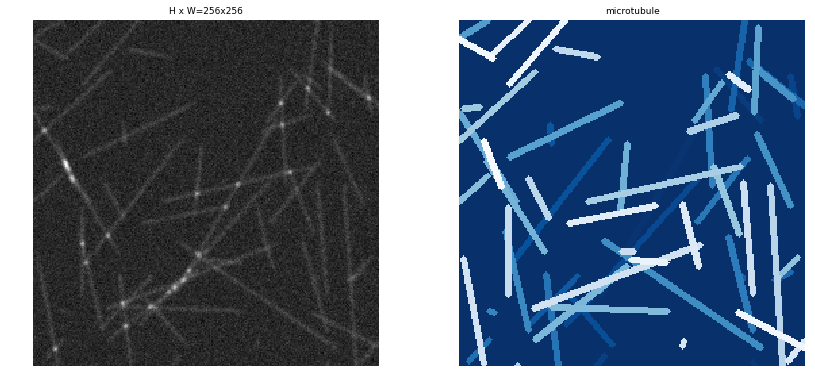

{'id': 57, 'source': 'microtubule', 'path': PosixPath('/home/hadim/local/Data/Neural_Networks/Microtubules/data/image_snr_1.2_n-mts_1_id_31.tif'), 'width': 256, 'height': 256, 'line_thickness': 4}


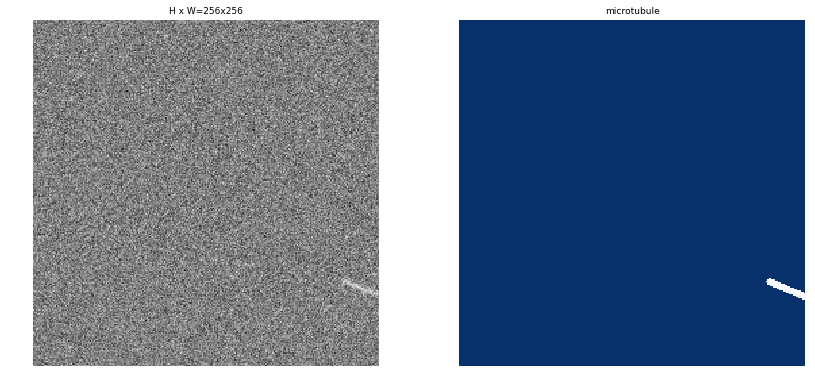

In [4]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 2, replace=True)
for image_id in image_ids:
    print(dataset.image_info[image_id])
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=1)

# Load Model

In [5]:
class MicrotubuleConfig(Config):
    NAME = "microtubule"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 1  # background + microtubule

    IMAGE_MIN_DIM = 10
    IMAGE_MAX_DIM = 512

    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)

    TRAIN_ROIS_PER_IMAGE = 32
    
config = MicrotubuleConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=str(model_dir))

# Load last weights
last_model_dir = Path(model.find_last()[0])
model_candidates = sorted(list(last_model_dir.glob(f"mask_rcnn_{config.NAME}_*.h5")))
model_path = model_candidates[-1]
model.load_weights(str(model_path), by_name=True)

## Review Weight Stats

In [6]:
# Show stats of all trainable weights    
visualize.display_weight_stats(model)

WEIGHT NAME,SHAPE,MIN,MAX,STD
conv1/kernel:0,"(7, 7, 3, 64)",-0.8509,+0.8413,+0.1322
conv1/bias:0,"(64,)",-0.0003,+0.0005,+0.0002
bn_conv1/gamma:0,"(64,)",+0.0835,+2.7392,+0.5260
bn_conv1/beta:0,"(64,)",-2.3924,+5.3670,+1.9777
bn_conv1/moving_mean:0,"(64,)",-173.0470,+116.3013,+44.5654
bn_conv1/moving_variance:0*** Overflow?,"(64,)",+0.0000,+146335.3594,+21847.9668
res2a_branch2a/kernel:0,"(1, 1, 64, 64)",-0.7046,+0.3732,+0.0792
res2a_branch2a/bias:0,"(64,)",-0.0061,+0.0064,+0.0027
bn2a_branch2a/gamma:0,"(64,)",+0.2169,+1.8472,+0.4115
bn2a_branch2a/beta:0,"(64,)",-2.1180,+3.7251,+1.1781


# Histograms of Weights

TODO: cleanup this part

In [ ]:
# Pick layer types to display
LAYER_TYPES = ['Conv2D', 'Dense', 'Conv2DTranspose']
# Get layers
layers = model.get_trainable_layers()
layers = list(filter(lambda l: l.__class__.__name__ in LAYER_TYPES, 
                layers))
# Display Histograms
fig, ax = plt.subplots(len(layers), 2, figsize=(10, 3*len(layers)),
                       gridspec_kw={"hspace":1})
for l, layer in enumerate(layers):
    weights = layer.get_weights()
    for w, weight in enumerate(weights):
        tensor = layer.weights[w]
        ax[l, w].set_title(tensor.name)
        _ = ax[l, w].hist(weight[w].flatten(), 50)
